# Assignment 2(due on 12/20)

## Student:郭悦怡（12332285），Gtihub：YueyiGuo
## 批改人：张鹏

## 得分：38/40+13/15

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import integrate
from sklearn.linear_model import LinearRegression

/home/zhangp/anaconda3/lib/python3.10/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## 1.1 Two-Box Model without Buffer Effect (Equations 1-2)

In [2]:
# Load carbon emission data 
ess = pd.read_csv("global_1751_2017.csv")
ess

,Year,Total carbon emissions from fossil fuel consumption and cement production (million metric tons of C),Carbon emissions from solid fuel consumption,Carbon emissions from liquid fuel consumption,Carbon emissions from gas fuel consumption,Carbon emissions from cement production,Carbon emissions from gas flaring,Per capita carbon emissions (metric tons of carbon; after 1949 only)
0,1751,3,3,0,0,0,0,0.00
1,1752,3,3,0,0,0,0,0.00
2,1753,3,3,0,0,0,0,0.00
3,1754,3,3,0,0,0,0,0.00
4,1755,3,3,0,0,0,0,0.00
...,...,...,...,...,...,...,...,...
262,2013,9568,4086,3233,1808,377,63,1.33
263,2014,9595,4060,3269,1816,385,65,1.32
264,2015,9623,3985,3339,1851,383,65,1.31
265,2016,9674,3915,3400,1899,390,69,1.28


In [3]:
# Calculate carbon fluxes
ess['co2fluxes'] = ess['Total carbon emissions from fossil fuel consumption and cement production (million metric tons of C)']

# Convert carbon fluxes to γ 
# !!! NOTE: 1 million metric tons = 1e-3 Pg
ess['Gamma'] = ess['co2fluxes'] /(1000 * 2.13)

# Define parameters and initial conditions
k12 = 105 /740
k21 = 102 /900
N1 = 740 /2.13  # Initial conditions
N2 = 900 /2.13  # Initial conditions
start_year = 1986
end_year = 2005

# Generate time series and define constants
time = np.arange(start_year, end_year+1, 1)
atmosphere = [N1]
ocean = [N2]

load所需数据之后进行提取处理，在进行多参数的定义和初始状态的设置。
其中我根据文章内容进行了单位转换

In [4]:
for t in range(start_year, end_year):
    gamma = ess.loc[ess['Year'] == t,'Gamma'].values[0]  # Calculate γ of the current year
    dNl_dt = -k12 * atmosphere[-1] + k21 * ocean[-1] + gamma
    dN2_dt = k12 * atmosphere[-1]- k21 * ocean[-1]
    
    N1_new = atmosphere[-1] + dNl_dt * 1
    N2_new = ocean[-1] + dN2_dt * 1
    atmosphere.append(N1_new)
    ocean.append(N2_new)

根据论文中的方程进行模型建立，代码如上

In [5]:
# Linear regression
tt = np.array(time[1: ].reshape(-1,1))
cc = np.array(atmosphere[1: ]).reshape(-1,1)
# Regression model
regression1 = LinearRegression()
regression1.fit(tt,cc)
line = regression1.predict(tt)

上面，我采用了sklearn包中的linear_model模型进行线性回归（LinearRegression）

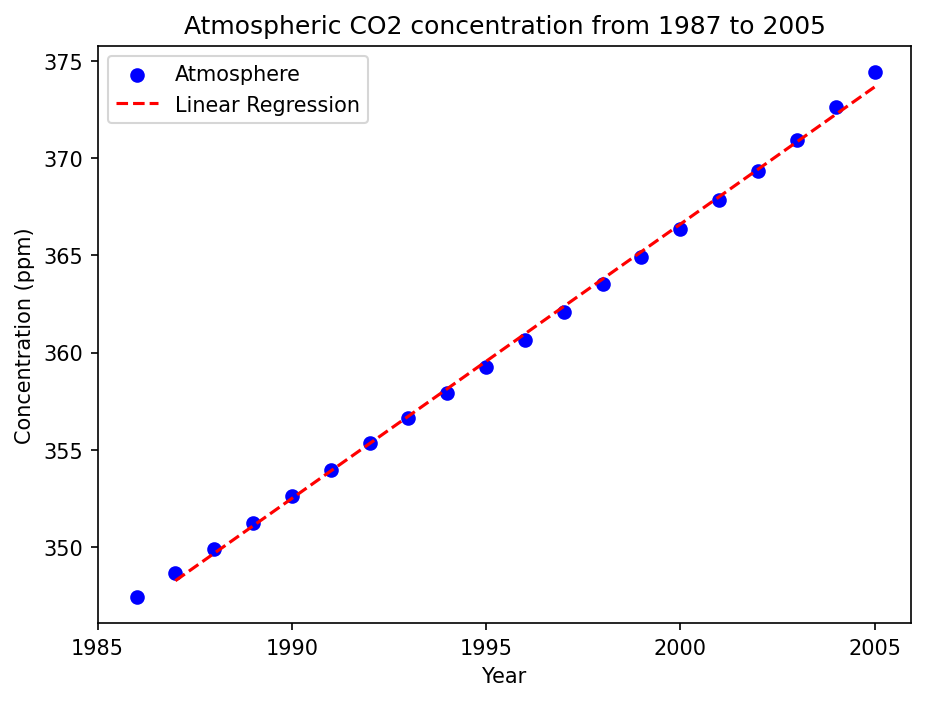

In [6]:
# Plot the results
fig = plt.figure(figsize=(7, 5),dpi=150) 
plt.scatter(time, atmosphere, marker = 'o', c='b', label='Atmosphere')
plt.plot(time[1:], line, color='r', linestyle='--', label='Linear Regression')
plt.xlabel('Year')
plt.ylabel("Concentration (ppm)")
plt.xticks([1985, 1990, 1995, 2000, 2005])
plt.title('Atmospheric CO2 concentration from 1987 to 2005')
plt.legend()

plt.show()

## 1.2  Two-Box Model with Buffer Effect (Equations 3-4)

In [7]:
# # Define parameters and initial conditions
k12 = 105 /740
k21 = 102 /900
N2_0= 821 /2.13
N11 = 740 /2.13
N22 = 900 /2.13

In [8]:
# Generate time series and define constants
start_year = 1986
end_year = 2005
time = np.arange(start_year,end_year+1,1)
atmosphere_with_buffer = [N11]
ocean_with_buffer =[N22]

进行多参数的定义和初始状态的设置。

In [9]:
for t in range(start_year, end_year):
    gamma = ess.loc[ess['Year'] == t, 'Gamma'].values[0]   # Calculate γ of the current vear
    z = atmosphere_with_buffer[-1]   # z is the atmospheric CO2 concentration of ppm unit,z= N1.
    ksi = 3.69 + 1.86e-2 * z - 1.8e-6 * z**2     # Calculate the buffer factor ξ，according to equation(A9）
    
    dN11_dt = -k12 * atmosphere_with_buffer[-1] + k21 * (N2_0 + ksi * (ocean_with_buffer[-1] - N2_0)) + gamma
    dN22_dt = k12 * atmosphere_with_buffer[-1] - k21 * (N2_0 + ksi * (ocean_with_buffer[-1] - N2_0))
    
    N11_new = atmosphere_with_buffer[-1] + dN11_dt * 1
    N22_new = ocean_with_buffer[-1] + dN22_dt * 1
    atmosphere_with_buffer.append(N11_new)
    ocean_with_buffer.append(N22_new)

In [10]:
# Linear regression
ttt = np.array(time[1:]).reshape(-1,1)
ccc = np.array(atmosphere_with_buffer[1:20]).reshape(-1,1)
regression2 = LinearRegression()
regression2.fit(ttt,ccc)
line_with_buffer = regression2.predict(ttt)

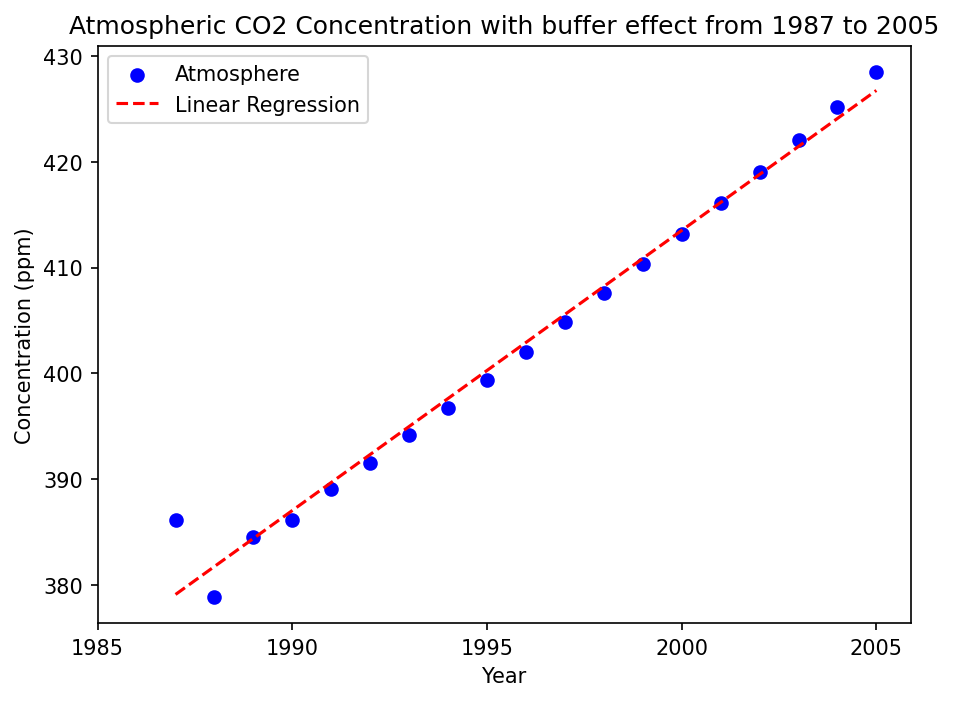

In [11]:
# Plotting the results
fig = plt.figure(figsize=(7, 5),dpi=150) 
plt.scatter(time[1:], atmosphere_with_buffer[1:20], marker = 'o', c='b',label='Atmosphere')
plt.plot(time[1:], line_with_buffer, color='r', linestyle='--', label='Linear Regression')
plt.xlabel('Year')
plt.ylabel('Concentration (ppm)')
plt.xticks([1985, 1990, 1995, 2000, 2005])
plt.title('Atmospheric CO2 Concentration with buffer effect from 1987 to 2005')
plt.legend()
plt.show()

## 1.3 Reproduce Fig. 2

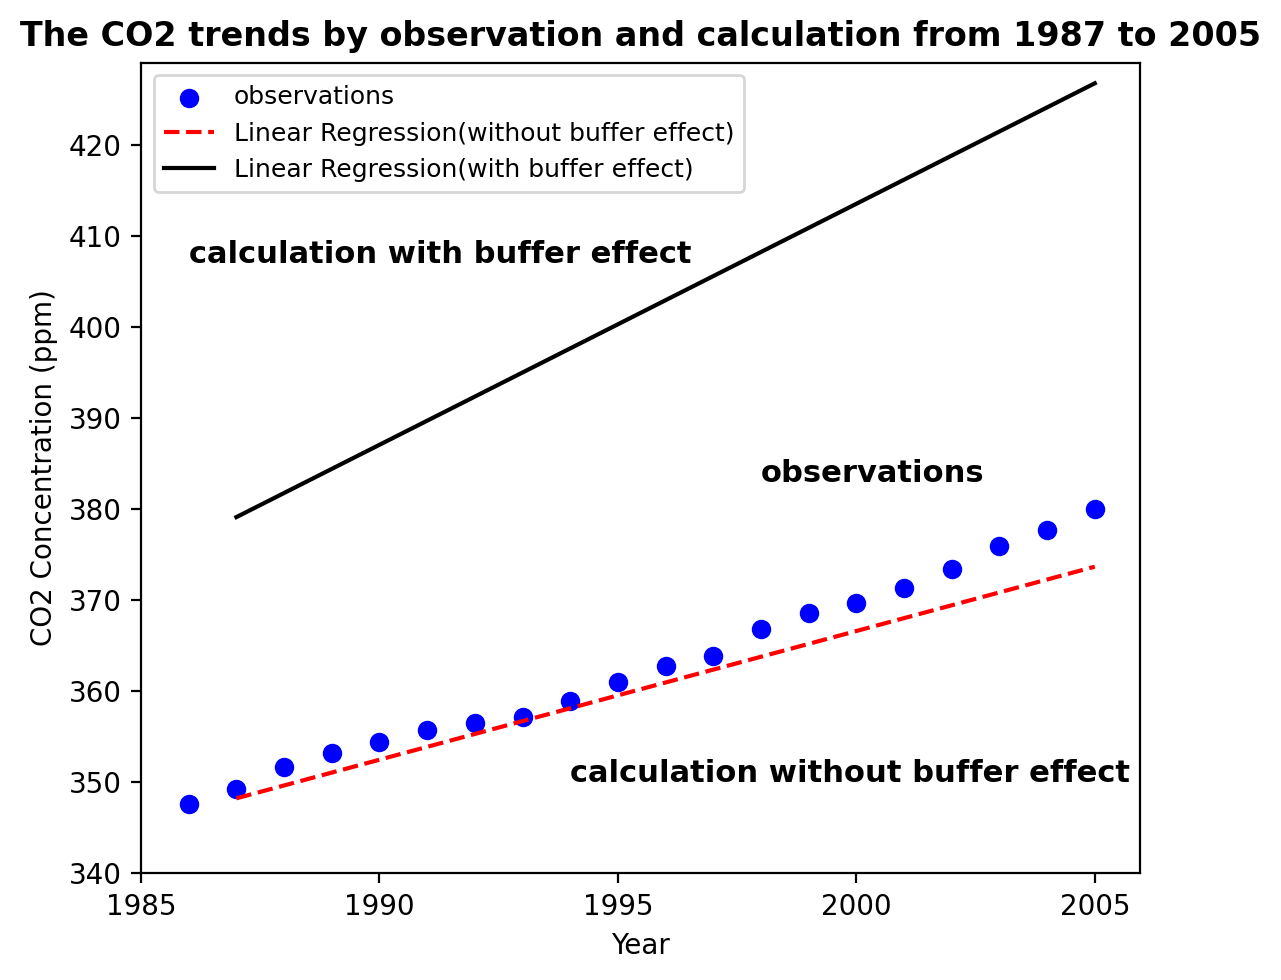

In [12]:
# Load the emissions data
obs = pd.read_csv('co2_annmean_mlo.csv')

# Filter data for the years 1986-2004
obs_1 = obs[(obs['year'] >= 1986) & (obs['year']<=2005)]

# Plotting and decorating
fig = plt.figure(figsize=(6, 5),dpi=200) 
plt.title('The CO2 trends by observation and calculation from 1987 to 2005',size=12,weight='bold')
plt.scatter(obs_1['year'], obs_1['mean'], marker='o', c='b', label='observations')
plt.plot(time[1:], line, c='r',linestyle='--',label='Linear Regression(without buffer effect)')
plt.plot(time[1:], line_with_buffer, color='k',linestyle='-',label='Linear Regression(with buffer effect)')

plt.text(1986, 407, 'calculation with buffer effect',size=11, weight='bold')
plt.text(1998, 383, 'observations',size=11, weight='bold')
plt.text(1994, 350, 'calculation without buffer effect',size=11, weight='bold')
plt.xlabel('Year')
plt.ylabel('CO2 Concentration (ppm)')
plt.xticks([1985, 1990, 1995, 2000, 2005])
plt.ylim(340,429)
plt.legend(prop = {'size': 9})

plt.tight_layout()
plt.show()

将1.1和1.2的运行结果进行整合处理，对比分析气象台站观测和模型计算拟合 的1987-2005年CO2浓度变化趋势。
可以看出有缓冲效应的数据计算结果偏高，无缓冲效应的数据和观测数据更贴近。

### 第一问代码思路和结果正确
### 第二问代码思路和结果正确
### 第三问结果正确。有结果分析
### 得分41/40

## Bonus:  The seven box model

In [13]:
# Load the carbon emissions data
ess = pd.read_csv('global_1751_2017.csv')
obs = pd.read_csv('co2_annmean_mlo.csv')
ff_lulc = pd.read_csv('feec_lulc_emissions.csv')
ice = pd.read_csv('ice.csv')

In [15]:
# unit conversion
lulc = ff_lulc[['Year','land-use change emissions']]
lulc['Delta'] = lulc['land-use change emissions']/(1000 * 2.13)

# Extract relevant columns
ess['co2fluxes'] = ess[['Year', 'Total carbon emissions from fossil fuel consumption and cement production (million metric tons of C)']]
# Calculate γ
ess['Gamma'] = ess['co2fluxes']/(1000 * 2.13)

# Define parameters
k12 = 60 /615
k21 = 60 /842
k23 = 9 /842
k24 = 43 /842
k32 = 52 /9744
k34 = 162 /9744
k43 = 205 /26280
k45 = 0.2 /26280
k51 = 0.2 / 9e7
k67 = 62 / 731
k71 = 62 /1238
N2_0= 842 /2.13
start_year=1750
end_year=1980
s_1=0.2
s_2=0.5
                       
fO = 62/ 2.13
atm1 = atmosphere
PO = 615 /2.13
beta =[0.38,0.5]

atmosphere_rr =[]

ValueError: Cannot set a DataFrame with multiple columns to the single column co2fluxes

In [ ]:
def seven_box_model(beta):
    year = np.arange(1750, 2001, 1)
    for t in range(start_year,end_year+1):
        f=[fO*(1 + beta*np.log(atmospherel-11/ PO))]
        gamma = ess.loc[ess['Year'] == t,'Gamma'].zero[0]
        delta = lulc.loc[lulc['Year'] == t, 'Delta'].zero[0]
        
        ......

整体思路同1.1-1.3，首先进行数据下载与处理过滤，在定义参数（注意单位换算），定义函数建立7box模型，进行运算

### 作答部分数据
### 得分 1/15